In [68]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from sympy import Matrix
import time
from scipy import sparse

In [69]:
"""
Idea is to index a 2D array using some 1D curve. Thus, there is an index mapping from each (x,y)->ind
Further, each site also has an adjancency set. This is the set of indices that are coupled to the site by an FM interaction
The model is defined using a 1xN field matrix and an NxN coupling matrix. The coupling matrix is sparse. N = LxW
"""
L= 3

def index_map(x, y, L):
    if x>L or y>L: return None
    return x*L + y

def square_lattice_dictionary(L):
    
    ind_dict = {}
    adj_ind = {}
    
    for x in range(L):
        for y in range(L):
            ind_0 = index_map(x,y,L)

            adjs = [index_map(x,(y+1)%L, L), index_map(x,(y-1)%L, L), index_map((x+1)%L,y, L), index_map((x-1)%L,y, L)]
            
            ind_dict[ind_0] = (x,y)
            adj_ind[ind_0] = adjs
    return ind_dict, adj_ind

def triangle_lattice_dictionary(L):
    ind_dict = {}
    adj_ind = {}
    
    for x in range(L):
        for y in range(L):
            ind_0 = index_map(x,y,L)
            
            #nn indices
            adjs = [index_map(x,(y+1)%L, L), index_map(x,(y-1)%L, L), index_map((x+1)%L,y, L), index_map((x-1)%L,y, L)]
            adjs.append(index_map((x+1)%L,(y-(-1)**(x%2))%L, L))
            adjs.append(index_map((x-1)%L,(y-(-1)**(x%2))%L, L))
            
            #nnn indices
            adjs += [index_map(x,(y+2)%L, L), index_map(x,(y-2)%L, L), index_map((x+2)%L,y, L), index_map((x-2)%L,y, L)]
            adjs += [index_map((x+2)%L,(y+1)%L, L), index_map((x+2)%L,(y-1)%L, L), index_map((x-2)%L,(y+1)%L, L), index_map((x-2)%L,(y-1)%L, L)]
            adjs += [index_map((x+1)%L,(y+(-1)**(x%2))%L, L), index_map((x+1)%L,(y-2*(-1)**(x%2))%L, L)]
            adjs += [index_map((x-1)%L,(y+(-1)**(x%2))%L, L), index_map((x-1)%L,(y-2*(-1)**(x%2))%L, L)] 
            
            ind_dict[ind_0] = (x,y)
            adj_ind[ind_0] = adjs
    return ind_dict, adj_ind

def triangle_nn_indices(L):
    adj_ind = {}
    
    for x in range(L):
        for y in range(L):
            ind_0 = index_map(x,y,L)
            
            #nn indices
            adjs = [index_map(x,(y+1)%L, L), index_map(x,(y-1)%L, L), index_map((x+1)%L,y, L), index_map((x-1)%L,y, L)]
            adjs.append(index_map((x+1)%L,(y-(-1)**(x%2))%L, L))
            adjs.append(index_map((x-1)%L,(y-(-1)**(x%2))%L, L))

            adj_ind[ind_0] = adjs
    return adj_ind

def triangle_nnn_indices(L):
    adj_ind = {}
    
    for x in range(L):
        for y in range(L):
            ind_0 = index_map(x,y,L)
            
            #nnn indices
            adjs = [index_map(x,(y+2)%L, L), index_map(x,(y-2)%L, L), index_map((x+2)%L,y, L), index_map((x-2)%L,y, L)]
            adjs += [index_map((x+2)%L,(y+1)%L, L), index_map((x+2)%L,(y-1)%L, L), index_map((x-2)%L,(y+1)%L, L), index_map((x-2)%L,(y-1)%L, L)]
            adjs += [index_map((x+1)%L,(y+(-1)**(x%2))%L, L), index_map((x+1)%L,(y-2*(-1)**(x%2))%L, L)]
            adjs += [index_map((x-1)%L,(y+(-1)**(x%2))%L, L), index_map((x-1)%L,(y-2*(-1)**(x%2))%L, L)] 
            
            adj_ind[ind_0] = adjs
    return adj_ind

ind_dict, adj_ind = triangle_lattice_dictionary(L)

def linear_fit(x, m, b):
    return m*x + b
def power_law(x, a):
    return x**(-a)

def power_law_scale(x, a, scale):
    return scale*x**(-a)

def exponential_dist_norm(x, a):
    return a*np.exp(-a*x)

def exponential_dist(x, A, b):
    return A*np.exp(-b*x)

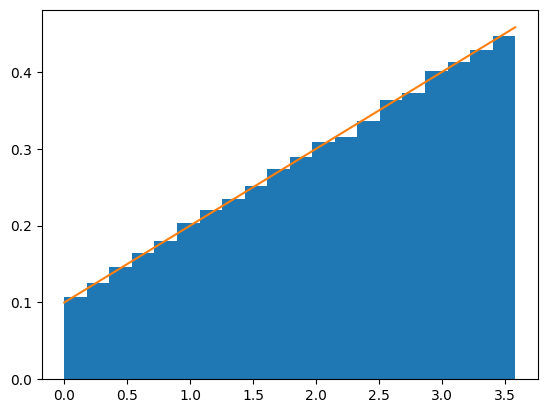

In [70]:
def random_nnDist(a,b,custDist,size=None, nControl=10**6):
    #genearte a list of size random samples, obeying the distribution custDist
    #suggests random samples between x0 and x1 and accepts the suggestion with probability custDist(x)
    #custDist noes not need to be normalized. Add this condition to increase performance. 
    #Best performance for max_{x in [x0,x1]} custDist(x) = 1
    samples=[]
    nLoop=0
    
    low = 0
    high = (np.sqrt(a**2 + 2*b) - a)/b
    
    while len(samples)<size and nLoop<nControl:
        x=np.random.uniform(low=low,high=high)
        prop=custDist(x, a, b)
        assert prop>=0 and prop<=1
        if np.random.uniform(low=0,high=1) <=prop:
            samples += [x]
        nLoop+=1
    return samples

def random_nnnDist(w,a,b,custDist,size=None, nControl=10**6):
    samples=[]
    nLoop=0
    
    low = w
    high = (np.sqrt(a**2 + 2*b*(1+a*w+b*w**2/2))-a)/b
    
    while len(samples)<size and nLoop<nControl:
        x=np.random.uniform(low=low,high=high)
        prop=custDist(x, a, b)
        assert prop>=0 and prop<=1
        if np.random.uniform(low=0,high=1) <=prop:
            samples += [x]
        nLoop+=1
    return samples


#call
a=0.1
b=0.1
def linDist(x, a, b):
    return a + b*x
samples=random_nnDist(a,b,custDist=linDist,size=100000)
#print(samples)

plt.hist(np.array(samples), density=True, bins = 20)

x = np.linspace(0, (np.sqrt(a**2 + 2*b) - a)/b, 1000)

plt.plot(x, np.array(linDist(x, a, b)))

In [71]:
def update_adjacency_J_ij(adj_ind, i, j):
    #Updates adjaceny set of i with that of j
    #Also deletes index from the adjacency list of other indices
    adj_i = adj_ind[i]
    adj_j = adj_ind[j]
    
    adj_i_new = list(set(adj_i+adj_j))
    adj_i_new = list(set(adj_i_new)-set([i, j]))
    adj_ind[i] = adj_i_new
    adj_ind[j] = []
    
    for k in adj_i_new:
        adj_ind[k] = list(set(adj_ind[k]+[i])-set([j]))
        
    return None

def update_adjacency_h(adj_ind, i):
    #Updates adjacency set of every element in adj(i) with adj(i)
    #Also deletes index i from adj(k) for all k in adj(i)
    adj_i = adj_ind[i]
    
    for k in adj_ind[i]:
        adj_ind[k] = list(set(adj_ind[k]+adj_i)-set([i]))
        
    adj_ind[i] = []
    return None
    

In [5]:
class system:
    
    def __init__(self, size, adj_ind, J_ij_vals, h_vals):
        
        self.size = size
        self.adj_ind = adj_ind
        self.J_ij_vals = J_ij_vals
        self.h_vals = h_vals
        
        self.Gamma_array = []
        self.Omega_0 = max(h_vals.max(), J_ij_vals.max())
        self.Omega = self.Omega_0
        return None
    
    def decimate(self):
        Omega = max(self.h_vals.max(), self.J_ij_vals.max())
        self.Omega = Omega
        self.Gamma_array.append(np.log(self.Omega_0/Omega))
        if Omega == self.J_ij_vals.max(): self.J_decimation(Omega)
        elif Omega == self.h_vals.max(): self.h_decimation(Omega)
        
        return None
    
    def J_decimation(self, Omega):
        r_ind, c_ind, J_ij = sparse.find(self.J_ij_vals) 
        J_ind = np.where(J_ij == Omega)[0][0]
        i, j = r_ind[J_ind], c_ind[J_ind]

        self.h_vals[i] = self.h_vals[i]*self.h_vals[j]/Omega    
        self.h_vals[j] = 0

        update_adjacency_J_ij(self.adj_ind, i, j)

        self.J_ij_vals[i,self.adj_ind[i]] = self.J_ij_vals[i, self.adj_ind[i]].maximum(self.J_ij_vals[j, self.adj_ind[i]])
        self.J_ij_vals[self.adj_ind[i], i] = self.J_ij_vals[i,self.adj_ind[i]]

        eye = chunk_deleter([j], self.size)
        self.J_ij_vals = eye @ self.J_ij_vals @ eye
        return None
    
    def h_decimation(self, Omega):
        i = np.where(self.h_vals == self.h_vals.max())[0][0]
        adj_i = self.adj_ind[i]
        J_ij_new = self.J_ij_vals[adj_i, i] @self.J_ij_vals[i, adj_i]/Omega

        self.J_ij_vals[adj_i, :][:, adj_i] = J_ij_new.maximum(self.J_ij_vals[adj_i,:][:, adj_i])

        self.h_vals[i] = 0

        eye = chunk_deleter([i], self.size)
        self.J_ij_vals = eye @ self.J_ij_vals @ eye

        update_adjacency_h(self.adj_ind, i)
        return None
        

In [6]:
L = 30

ind_dict, adj_ind = triangle_lattice_dictionary(L)
nn_ind = triangle_nn_indices(L)
nnn_ind = triangle_nnn_indices(L)

J_ij_vals = fill_J_ij_matrix(L*L, nn_ind, nnn_ind, a, b)
h_vals = np.exp(-np.random.exponential(size=L*L))

test = system(L*L, adj_ind, J_ij_vals, h_vals)

NameError: name 'fill_J_ij_matrix' is not defined

In [7]:
steps = 700
check_list = np.array([0, 300, 600])

for i in range(steps):
    test.decimate()
    if i in check_list:
        h_remain = test.h_vals
        h_remain = h_remain[h_remain!=0]
        n,bins = np.histogram(-np.log(h_remain/test.Omega), density=True, bins = 50)
        width = bins[1]-bins[0]
        plt.scatter(bins[1:]-width/2, n)

#plt.xscale('log')
plt.yscale('log')

NameError: name 'test' is not defined

In [53]:
from scipy import sparse
L = 4
ind_dict, adj_ind = square_lattice_dictionary(L)
a, b = (0.1, 0.1)

In [54]:
def fill_J_ij_matrix(size, nn_ind, nnn_ind, a, b, include_nnn=True):
    J_ij_vals = sparse.lil_matrix((size, size))
    for ind in range(size):
        
        #Filling nn bonds
        adj_ind_array = np.array(nn_ind[ind])
        upper_ind = adj_ind_array[adj_ind_array>ind]
        
        J_ij_vals[ind, upper_ind] = sparse.lil_matrix(np.exp(-np.array(random_nnDist(a/3.0, b/3.0, custDist=linDist, size=len(upper_ind)))))
        
        if include_nnn:
            #Filling nnn bonds
            w = (np.sqrt((a/3)**2 + 2*(b/3)) - a/3)/(b/3)
            adj_ind_array = np.array(nnn_ind[ind])
            upper_ind = adj_ind_array[adj_ind_array>ind]

            J_ij_vals[ind, upper_ind] = sparse.lil_matrix(np.exp(-np.array(random_nnnDist(w, a/6.0, b/6.0, custDist=linDist, size=len(upper_ind)))))

    return J_ij_vals + J_ij_vals.T

def chunk_deleter(ind_array, size):
    eye_diag = np.ones(size)
    eye_diag[ind_array] = 0
    return sparse.diags(eye_diag)

def resparse(spr_mat, size, tol):
    i_ind, j_ind, vals = sparse.find(spr_mat)
    mask = vals>tol
    i_new, j_new, val_new = i_ind[mask], j_ind[mask], vals[mask]
    
    return sparse.csr_matrix((val_new, (i_new, j_new)), shape=(size, size))

In [10]:


#fill_J_ij_matrix(L, adj_ind, a, b)
L, a, b = 100, 0.1, 0.1
nn_ind = triangle_nn_indices(L)
nnn_ind = triangle_nnn_indices(L)
t = time.time()
J_ij_vals = fill_J_ij_matrix(L*L, nn_ind, nnn_ind, a, b, include_nnn=False)
print(-t+time.time())

3.265859365463257


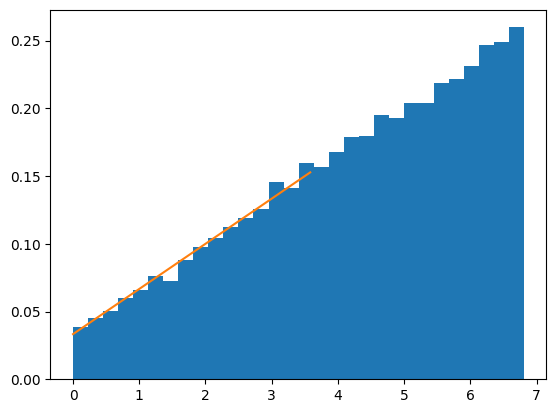

In [11]:
plt.hist(-np.log(sparse.find(J_ij_vals)[2]), density = 'True', bins=30)
x = np.linspace(0, (np.sqrt(a**2 + 2*b) - a)/b, 1000)

plt.plot(x, np.array(linDist(x, a/3, b/3)))

In [36]:
L = 50
steps = 2200
runs = 1
measure_step = 20
R0_array_sum = np.zeros(int(steps/measure_step))

cluster_tracker = np.ones(L*L)

a_vals = np.array([0.1])#np.arange(0.05, 0.2, 0.02)
b_vals = np.array([0.105])#np.arange(0.1,0.3,0.03)

for run in range(runs):
    Gamma_array = np.zeros(shape=(len(a_vals), len(b_vals), steps))
    R0_array = []
    mu_array = []
    #R0_array_err = []

    t_total_Jij = 0
    t_total_h = 0

    for l, a in enumerate(a_vals):
        for m, b in enumerate(b_vals):

            ind_dict, adj_ind = triangle_lattice_dictionary(L)
            nn_ind = triangle_nn_indices(L)
            nnn_ind = triangle_nnn_indices(L)

            J_ij_vals = fill_J_ij_matrix(L*L, nn_ind, nnn_ind, a, b)
            h_vals = np.exp(-np.random.exponential(size=L*L))

            Omega_0 = max(h_vals.max(), J_ij_vals.max())
            for step in range(steps):

                if step%1000 == 0: print ("Step: "+str(step)+"/"+str(steps))
                Omega = max(h_vals.max(), J_ij_vals.max())
                Gamma_array[l,m,step] = (np.log(Omega_0/Omega))
                #J_ij_vals = resparse(J_ij_vals, L*L, Omega*(1-steps/(L*L)))

                if Omega == J_ij_vals.max():
                    """
                    Strongest term is an Ising coupling -> Renormalizes to a field given by h_i * h_j/J_ij
                    Delete one of the elements (say h_i), shortening h_vals
                    Update adjacency of j to include both adj(i) and adj(j)
                    Set new Jnew_jk = max (J_jk, J_ik)
                    Delete the corresponding row and column in J_ij (J_i* and J*i) and set the adjacency of i to []
                    """
                    t0 = time.time()
                    r_ind, c_ind, J_ij = sparse.find(J_ij_vals) 
                    J_ind = np.where(J_ij == Omega)[0][0]
                    i, j = r_ind[J_ind], c_ind[J_ind]

                    h_vals[i] = h_vals[i]*h_vals[j]/Omega    #Might need to include a factor of 2 here since we are symmetrizing later
                    h_vals[j] = 0

                    update_adjacency_J_ij(adj_ind, i, j)

                    J_ij_vals[i,adj_ind[i]] = J_ij_vals[i, adj_ind[i]].maximum(J_ij_vals[j, adj_ind[i]])
                    J_ij_vals[adj_ind[i], i] = J_ij_vals[i,adj_ind[i]]

                    eye = chunk_deleter([j], L*L)
                    J_ij_vals = eye @ J_ij_vals @ eye
                    t_total_Jij += time.time()-t0
                    cluster_tracker[i] += cluster_tracker[j]
                    cluster_tracker[j] = 0
                elif Omega == h_vals.max():
                    """
                    """
                    t0 = time.time()
                    i = np.where(h_vals == h_vals.max())[0][0]
                    adj_i = adj_ind[i]
                    J_ij_new = J_ij_vals[adj_i, i] @J_ij_vals[i, adj_i]/Omega

                    J_ij_vals[adj_i, :][:, adj_i] = J_ij_new.maximum(J_ij_vals[adj_i,:][:, adj_i])

                    h_vals[i] = 0

                    eye = chunk_deleter([i], L*L)
                    J_ij_vals = eye @ J_ij_vals @ eye

                    update_adjacency_h(adj_ind, i)
                    t_total_h += time.time()-t0
                if step%measure_step == 0:
                    h_vals_remain = h_vals[h_vals!=0]
                    cluster_moments = cluster_tracker[cluster_tracker!=0]
                    n,bins = np.histogram(-np.log(h_vals_remain/Omega), density=True, bins = 60)

                    width = bins[1]-bins[0]
                    popt, pcov = curve_fit(exponential_dist_norm, (bins[1:]-width/2)[:20], n[:20])
                    R0_array.append(popt[0])
                    mu_array.append(cluster_moments.mean())
                    #R0_array_err.append(pcov[0][0])
    R0_array_sum += np.array(R0_array)

Step: 0/2200
0.9995592667774512
0.9916702620106
0.9813769077016834
0.9745340464574369
0.9642375178470333
0.9581859698288727
0.9542137784051766
0.9467143377959172
0.9402489832420222
0.9324535034577013
0.9263277900467607
0.9187203317145376
0.9137896081017737
0.9056748194154053
0.9007853251511466
0.8935998259996367
0.886449987693491
0.8784183697462785
0.8695948177339629
0.8622528665573821
0.8556009675471101
0.8494320690341418
0.8446257927999998
0.8385917911760128
0.8315410844675332
0.822804481754634
0.8131845933938864
0.8045396246488898
0.7924650729463684
0.7850280585602106
0.7766977923079219
0.7670113629696573
0.7544266868555053
0.7478915847517643
0.7416071282825418
0.7355971293615102
0.7288382077816105
0.7222635724058107
0.7157912831142507


KeyboardInterrupt: 

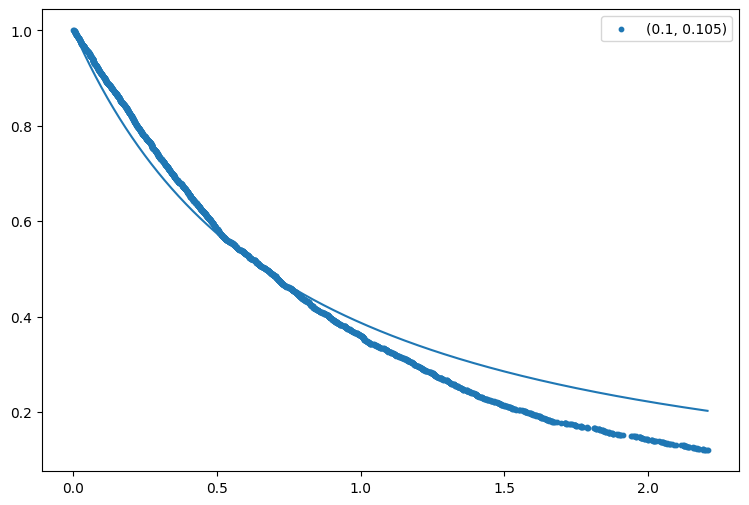

In [17]:
n_array = (- np.arange(steps)+(L*L))/(L*L)
plt.figure(figsize=(9, 6))
for l, a in enumerate(a_vals):
    for m, b in enumerate(b_vals):
        plt.scatter(Gamma_array[l,m,:],  n_array, s=10, label="("+str(a)+', '+str(b)+")")
plt.plot(Gamma_array[0,0,:], (Gamma_array[0,0,:]+1)**(-1.368))



plt.legend()
#plt.xlim(0, 10)

/tmp/ipykernel_787/3301101615.py:89: RuntimeWarning: overflow encountered in power
  return scale*x**(-a)
/tmp/ipykernel_787/3301101615.py:89: RuntimeWarning: overflow encountered in multiply
  return scale*x**(-a)


[0.13393806 2.68402585]
0.26787611766210795


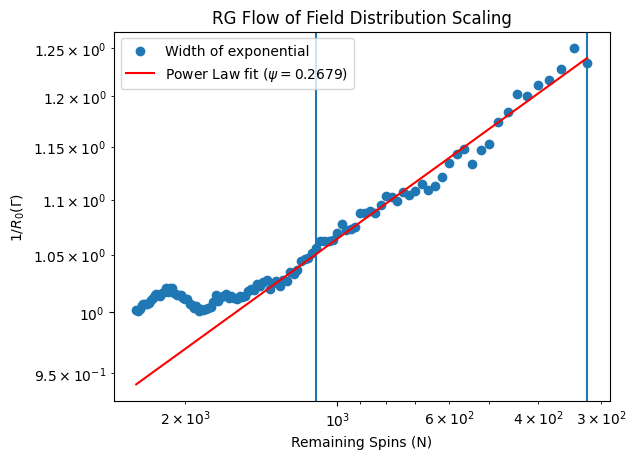

In [35]:

x = L*L - np.arange(len(R0_array))*measure_step
y = runs/np.array(R0_array_sum)
R_length = len(y)

start = 70
end = -1

plt.axvline(x = x[start])
plt.axvline(x = x[end])
plt.scatter(x, y, label='Width of exponential')#, yerr=np.sqrt(np.array(R0_array_err))/np.array(R0_array)**2)
#plt.yscale('log')

popt, pcov = curve_fit(power_law_scale, x[start:end], y[start:end])
print(popt)
print(popt[0]*2)

plt.title("RG Flow of Field Distribution Scaling")
plt.xlabel("Remaining Spins (N)")
plt.ylabel(r"$1/R_0(\Gamma)$")
plt.plot(x, power_law_scale(x, *popt), color='red', label=r'Power Law fit ($\psi=$'+str(round(popt[0]*2, 4))+')')

plt.gca().invert_xaxis()
plt.legend()
plt.yscale('log')
plt.xscale('log')

#plt.xlim(1e4, 0.8*1e3)

[-0.05362113  0.36462037]


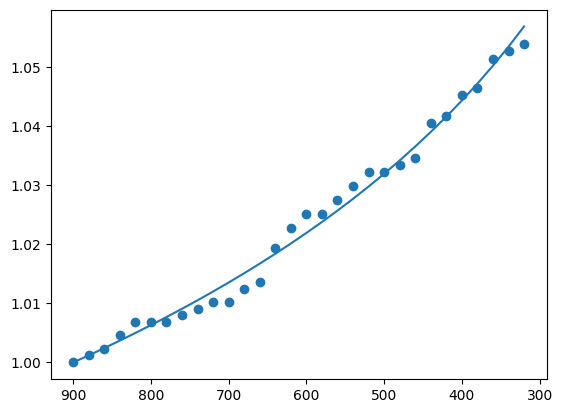

In [17]:
log_x = np.log(x)
log_mu = np.log(np.array(mu_array))

plt.scatter(np.exp(log_x), np.exp(log_mu))
plt.gca().invert_xaxis()

popt, pcov = curve_fit(linear_fit,log_x , log_mu)

plt.plot(np.exp(log_x), np.exp(linear_fit(log_x, *popt)))
#plt.xscale('log')
#plt.yscale('log')
print(popt)

In [25]:
popt, pcov = curve_fit(power_law_scale, x[-150:], 1/np.array(R0_array)[-150:])
print(popt)
print(popt[0]*2)

[8.28500272e-01 8.51654087e+03]
1.6570005448906635


C:\Users\tsgau\AppData\Local\Temp\ipykernel_13980\2578980702.py:41: RuntimeWarning: overflow encountered in power
  return scale*x**(-a)


In [96]:
print(t_total_Jij)
print(t_total_h)

510.70387864112854
378.47939229011536


In [203]:
popt, pcov = curve_fit(power_law, Gamma_array[0,0,:]+1, n_array)
popt

array([1.36841463])

[1.48256195 0.80559606]


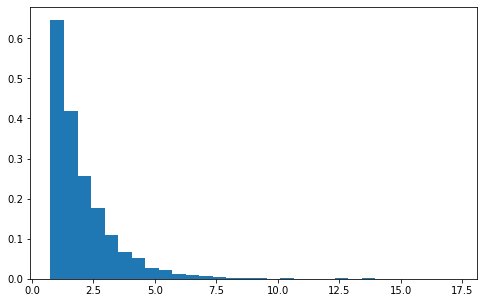

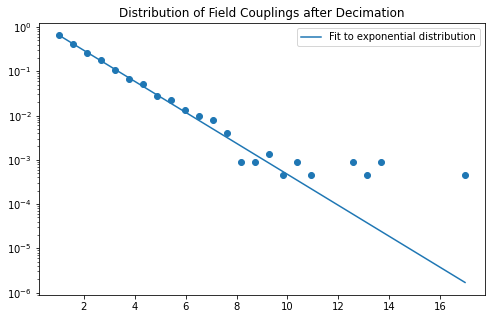

In [134]:
h_vals_remain = h_vals[h_vals!=0]
plt.figure(figsize=(8,5))
n,bins, pacthes = plt.hist(-np.log(h_vals_remain), density=True, bins = 30)

width = bins[1]-bins[0]

plt.figure(figsize=(8,5))
x_data = bins[1:]-width/2
popt, pcov = curve_fit(exponential_dist,x_data, n)

plt.plot(x_data, exponential_dist(x_data, *popt), label='Fit to exponential distribution')
plt.scatter(x_data, n)
plt.title("Distribution of Field Couplings after Decimation")
plt.yscale('log')
plt.legend()
print(popt)

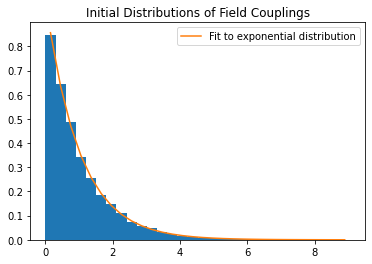

In [112]:
h_vals_ini = np.exp(-np.random.exponential(size=L*L))
n,bins, pacthes = plt.hist(-np.log(h_vals_ini), density=True, bins = 30)

width = bins[1]-bins[0]


x_data = bins[1:]-width/2
popt, pcov = curve_fit(exponential_dist,x_data, n)

plt.plot(x_data, exponential_dist(x_data, *popt), label='Fit to exponential distribution')
plt.title("Initial Distributions of Field Couplings")
plt.legend()

In [92]:
def triangle_lattice_boundary_dictionary(L):
    ind_dict = {}
    adj_ind = {}
    bdry_dict = np.zeros(L*L,dtype=bool)
    
    for x in range(L):
        for y in range(L):
            ind_0 = index_map(x,y,L)
            
            #nn indices
            adjs = [index_map(x,(y-1)%L, L), index_map(x,(y+1)%L, L)]
            
            adjs += [index_map(x,(y+2)%L, L), index_map(x,(y-2)%L, L)]
            
            if x-1>=0:
                adjs.append(index_map((x-1)%L,y, L))
                adjs.append(index_map((x-1)%L,(y-(-1)**(x%2))%L, L))
                
                adjs += [index_map((x-1)%L,(y+(-1)**(x%2))%L, L), index_map((x-1)%L,(y-2*(-1)**(x%2))%L, L)]
            if x+1<L:
                adjs.append(index_map((x+1)%L,y, L))
                adjs.append(index_map((x+1)%L,(y-(-1)**(x%2))%L, L))
                
                adjs += [index_map((x+1)%L,(y+(-1)**(x%2))%L, L), index_map((x+1)%L,(y-2*(-1)**(x%2))%L, L)]
            
            if x-2>=0:
                adjs += [index_map((x-2)%L,y, L), index_map((x-2)%L,(y+1)%L, L), index_map((x-2)%L,(y-1)%L, L)]
            if x+2<L:
                adjs += [index_map((x+2)%L,y, L), index_map((x+2)%L,(y+1)%L, L), index_map((x+2)%L,(y-1)%L, L)]
            
            if x==0: bdry_dict[ind_0] = True
            elif x==(L-1): bdry_dict[ind_0] = True      
                
            ind_dict[ind_0] = (x,y)
            adj_ind[ind_0] = adjs
    return ind_dict, adj_ind, bdry_dict

In [93]:
ind_dict, adj_ind, bdry_dict = triangle_lattice_boundary_dictionary(4)

In [94]:
class boundary_system:
    
    def __init__(self, size, adj_ind, bdry_dict, J_ij_vals, h_vals):
        
        self.size = size
        self.adj_ind = adj_ind
        self.J_ij_vals = J_ij_vals
        self.h_vals = h_vals
        self.bdry_dict = bdry_dict
        
        self.Gamma_array = []
        self.Omega_0 = max(h_vals.max(), J_ij_vals.max())
        self.Omega = self.Omega_0
        return None
    
    def decimate(self):
        Omega = max(self.h_vals.max(), self.J_ij_vals.max())
        self.Omega = Omega
        self.Gamma_array.append(np.log(self.Omega_0/Omega))
        if Omega == self.J_ij_vals.max(): self.J_decimation(Omega)
        elif Omega == self.h_vals.max(): self.h_decimation(Omega)
        
        return None
    
    def J_decimation(self, Omega):
        r_ind, c_ind, J_ij = sparse.find(self.J_ij_vals) 
        J_ind = np.where(J_ij == Omega)[0][0]
        i, j = r_ind[J_ind], c_ind[J_ind]

        self.h_vals[i] = self.h_vals[i]*self.h_vals[j]/Omega    
        self.h_vals[j] = 0
        self.bdry_dict[i] = self.bdry_dict[i] or self.bdry_dict[j]
        self.bdry_dict[j] = False
        
        update_adjacency_J_ij(self.adj_ind, i, j)

        self.J_ij_vals[i,self.adj_ind[i]] = self.J_ij_vals[i, self.adj_ind[i]].maximum(self.J_ij_vals[j, self.adj_ind[i]])
        self.J_ij_vals[self.adj_ind[i], i] = self.J_ij_vals[i,self.adj_ind[i]]

        eye = chunk_deleter([j], self.size)
        self.J_ij_vals = eye @ self.J_ij_vals @ eye
        return None
    
    def h_decimation(self, Omega):
        i = np.where(self.h_vals == self.h_vals.max())[0][0]
        adj_i = self.adj_ind[i]
        J_ij_new = self.J_ij_vals[adj_i, i] @self.J_ij_vals[i, adj_i]/Omega

        self.J_ij_vals[adj_i, :][:, adj_i] = J_ij_new.maximum(self.J_ij_vals[adj_i,:][:, adj_i])

        self.h_vals[i] = 0

        eye = chunk_deleter([i], self.size)
        self.J_ij_vals = eye @ self.J_ij_vals @ eye

        update_adjacency_h(self.adj_ind, i)
        return None
        

In [102]:
L = 50
steps = int(0.95*L*L)
a, b = 0.1, 0.105
measure_step = 20

ind_dict, adj_ind, bdry_dict = triangle_lattice_boundary_dictionary(L)
nn_ind = triangle_nn_indices(L)
nnn_ind = triangle_nnn_indices(L)

check_list = np.floor(L*L*(1- 1/(2.5**np.arange(10))))

runs = 100

In [103]:
for run in range(runs):  
    J_ij_vals = fill_J_ij_matrix(L*L, nn_ind, nnn_ind, a, b)
    h_vals = np.exp(-np.random.exponential(size=L*L))
    test = boundary_system(L*L, adj_ind, bdry_dict, J_ij_vals, h_vals)

    
    R0_array = np.zeros(1+int(steps/measure_step))
    R0_array_copy = np.zeros(1+int(steps/measure_step))
    

    for i in range(steps):
        test.decimate()
        if i%measure_step==0:
            h_remain = test.h_vals[~bdry_dict]
            h_remain = h_remain[h_remain!=0]
            n,bins = np.histogram(-np.log(h_remain/test.Omega), density=True, bins = 60)
            width = bins[1]-bins[0]

            popt, pcov = curve_fit(exponential_dist_norm, (bins[1:]-width/2)[:20], n[:20])
            R0_array[int(i/measure_step)] += popt[0]

            n,bins = np.histogram(-np.log(h_remain/test.Omega), density=True, bins =30)
            width = bins[1]-bins[0]

            popt, pcov = curve_fit(exponential_dist_norm, (bins[1:]-width/2)[:10], n[:10])
            R0_array_copy[int(i/measure_step)] += popt[0]
        """if i in check_list:
            h_remain = test.h_vals
            h_remain = h_remain[h_remain!=0]
            n,bins = np.histogram(-np.log(h_remain/test.Omega), density=True, bins = 60)
            width = bins[1]-bins[0]

            popt, pcov = curve_fit(exponential_dist_norm, (bins[1:]-width/2)[:20], n[:20])
            plt.scatter(bins[1:]-width/2, n, label="N="+str(L*L - i), s=10)
            plt.plot(bins[1:]-width/2, exponential_dist_norm(bins[1:]-width/2, *popt))"""
        

#plt.xscale('log')
"""plt.xlabel(r"Log field coupling $\beta$")
plt.ylabel(r"Distribution $R(\beta)$")
plt.title("Distribution of Field Couplings")
plt.yscale('log')
plt.xlim(0.01, 4)
plt.legend()
plt.ylim(0.01, 1)"""

'plt.xlabel(r"Log field coupling $\x08eta$")\nplt.ylabel(r"Distribution $R(\x08eta)$")\nplt.title("Distribution of Field Couplings")\nplt.yscale(\'log\')\nplt.xlim(0.01, 4)\nplt.legend()\nplt.ylim(0.01, 1)'

[2.03222831e-01 4.42774829e+02]
0.4064456622561081


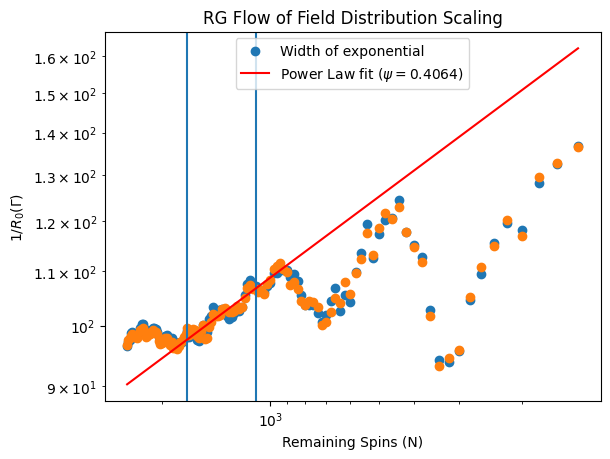

In [105]:
x = L*L - np.arange(len(R0_array))*measure_step
y = runs/R0_array
R_length = len(y)

start = 40
end = 70

plt.axvline(x = x[start])
plt.axvline(x = x[end])
plt.scatter(x, y, label='Width of exponential')#, yerr=np.sqrt(np.array(R0_array_err))/np.array(R0_array)**2)

y2 = runs/np.array(R0_array_copy)
plt.scatter(x, y2)

#plt.yscale('log')

popt, pcov = curve_fit(power_law_scale, x[start:end], y[start:end])
print(popt)
print(popt[0]*2)

plt.title("RG Flow of Field Distribution Scaling")
plt.xlabel("Remaining Spins (N)")
plt.ylabel(r"$1/R_0(\Gamma)$")
plt.plot(x, power_law_scale(x, *popt), color='red', label=r'Power Law fit ($\psi=$'+str(round(popt[0]*2, 4))+')')

plt.gca().invert_xaxis()
plt.legend()
plt.yscale('log')
plt.xscale('log')

#plt.xlim(1e4, 0.8*1e3)